<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -10px">
        <strong>Curso:</strong> Procesamiento de Lenguaje Natural
        <strong>Sección:</strong> 10
        <strong>Repositorio:</strong> https://github.com/Dahernandezsilve/NLP-Practical-Solution.git
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Proyecto:</strong> Aplicación práctica</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autores:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
        <li>Linda Inés Jiménez Vides - <strong>21169</strong></li>
        <li>Mario Antonio Guerra Morales - <strong>21008</strong></li>
        <li>Adrian Fulladolsa Palma - <strong>21592</strong></li>
      </ul>
    </td>
  </tr>
</table>

## 📚 Diccionario de columnas del dataset `biglam/spanish_golden_age_sonnets`

El siguiente diccionario describe detalladamente cada campo del corpus de sonetos del Siglo de Oro español, incluyendo su significado, contenido esperado y relevancia dentro del modelo **baseline** (discriminador y generador).

| Columna | Tipo | Descripción formal | Uso en el baseline |
|--------|------|--------------------|--------------------|
| **`author`** | `string` | Nombre del autor al que se atribuye el soneto. Corresponde a la etiqueta principal utilizada en tareas de clasificación supervisada. | ✅ **Sí.** Variable objetivo (*target*) del modelo discriminador. Permite entrenar el clasificador para atribuir textos a un autor específico. |
| **`sonnet_title`** | `string` | Título original del soneto. En algunos casos puede estar ausente o ser genérico. | 🟡 **Opcional.** Puede utilizarse en análisis exploratorio de datos (EDA), pero no aporta información relevante al modelo baseline. |
| **`sonnet_text`** | `string` | Texto completo del soneto en español, estructurado en versos separados por saltos de línea (`\n`). Representa el contenido literario principal del corpus. | ✅ **Sí.** Es la fuente textual utilizada para construir las representaciones TF-IDF en el modelo discriminador y para entrenar el modelo generador basado en *n*-gramas. Constituye la entrada fundamental del sistema. |
| **`metric_pattern`** | `string` | Patrón métrico del soneto expresado en formato TEI, detallando la estructura silábica y rítmica verso por verso. | 🟡 **Opcional.** No se utiliza en el baseline, pero constituye un recurso valioso para futuras etapas del proyecto (e.g., análisis estilométrico avanzado o generación controlada). |
| **`reference_id`** | `int` | Identificador único del archivo XML del cual se extrajo el soneto en la edición crítica. | ❌ **No.** Es un metadato de procedencia sin utilidad predictiva directa. |
| **`publisher`** | `string` | Nombre de la editorial responsable de la publicación de la obra. | ❌ **No.** Metadato bibliográfico. Su inclusión podría inducir sesgos o fugas de información si existe correlación con el autor. |
| **`editor`** | `string` | Nombre del editor o editora responsable de la edición moderna del texto. | ❌ **No.** Metadato sin relevancia lingüística o estilística para los modelos. |
| **`research_author`** | `string` | Nombre del autor o autora principal del trabajo académico asociado al corpus. | ❌ **No.** Metadato de contexto académico. No aporta información útil para tareas de modelado lingüístico. |
| **`metrical_patterns_annotator`** | `string` | Nombre del especialista que revisó o anotó el patrón métrico de los sonetos. | ❌ **No.** Metadato sin valor para el entrenamiento de modelos de clasificación o generación. |
| **`research_group`** | `string` | Nombre del grupo de investigación que compiló y procesó el corpus. | ❌ **No.** Información contextual que no interviene en el análisis textual. |

---

### Utilizados en el baseline

- ✅ **`author`** — etiqueta de clasificación para el modelo discriminador.  
- ✅ **`sonnet_text`** — contenido textual principal para entrenamiento y generación.  

Librerías

In [1]:
import torch

print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("Capacidad de cómputo:", torch.cuda.get_device_capability())

x = torch.randn(2, 2, device="cuda")
print("Tensor en GPU OK:", x)


torch.__version__: 2.9.1+cu128
torch.version.cuda: 12.8
CUDA disponible: True
GPU: NVIDIA GeForce RTX 5070 Laptop GPU
Capacidad de cómputo: (12, 0)
Tensor en GPU OK: tensor([[-0.1456,  0.2174],
        [-0.4851,  0.9567]], device='cuda:0')


In [2]:
import nltk
import numpy as np
import pandas as pd
import random, re, os, json
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.svm import LinearSVC
from rouge_score import rouge_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import classification_report, confusion_matrix, f1_score

nltk.download("stopwords")
spanish_stopwords = stopwords.words("spanish")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
pd.set_option("display.max_colwidth", 240)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carga del dataset

In [3]:
ds = load_dataset("biglam/spanish_golden_age_sonnets")
print(ds)                       # Vista general (splits)
print("Columnas:", ds["train"].column_names)
sample = ds["train"][0]
sample

DatasetDict({
    train: Dataset({
        features: ['author', 'sonnet_title', 'sonnet_text', 'metric_pattern', 'reference_id', 'publisher', 'editor', 'research_author', 'metrical_patterns_annotator', 'research_group'],
        num_rows: 5077
    })
})
Columnas: ['author', 'sonnet_title', 'sonnet_text', 'metric_pattern', 'reference_id', 'publisher', 'editor', 'research_author', 'metrical_patterns_annotator', 'research_group']


{'author': 'Martín de la  Plaza,  Luis',
 'sonnet_title': 'Martín de la Plaza, Luis Antequera (Málaga). 77 -  Sacerdote de la Colegiata de su ciudad natal. Soneto ',
 'sonnet_text': '\nCubierto estaba el Sol de un negro velo,\nluchaba el viento con el mar hinchado\ny él en huecos peñascos quebrantado\ncon blanca espuma salpicaba el cielo.\n\nEl ronco trueno amenazaba el suelo,\ntocaba el rayo al monte levantado\ny pardas nubes de granizo helado\nel campo cobijaban con su hielo.\n\nMas luego que su clara luz mostraron\nlos bellos ojos que contento adoro\ny a quien el alba envidia los colores,\n\ncalmó el mar, calló el viento y se ausentaron\nlos truenos, pintó el Sol las nubes de oro,\nvistiose el campo de olorosas flores.\n',
 'metric_pattern': '-+-+-+++-+-\n-+-+---+-+-\n-+---+-+-+-\n-++-++---+-\n',
 'reference_id': 1,
 'publisher': 'Biblioteca Virtual Miguel de Cervantes',
 'editor': 'Ramón García González',
 'research_author': 'Borja Navarro Colorado',
 'metrical_patterns_annotator':

In [4]:
df = pd.DataFrame(ds["train"])
expected = ["author", "sonnet_text"]
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas esperadas: {missing}. Columnas reales: {list(df.columns)}")

# print(df.head(3))
print("\nAutores distintos:", df["author"].nunique())
df["author"].value_counts().head(20)


Autores distintos: 52


author
Lope de Vega                   1346
Quevedo                         517
Fernando de Herrera             320
Gutierre de Cetina              247
Argensola                       218
Juan de Tassis y Peralta        203
Joseph de Litala y Castelvi     152
Fcode Borja                     142
Pedro Soto de Rojas             125
Gongora                         115
Luis de Ulloa y Pereira         106
Juan Boscan                     100
Hernandode Acunya                84
Francisco de La Torre            78
Bocangel y Unzueta               77
Cervantes                        77
Juana Ines de La Cruz            72
Arguijo,  Juan de                70
Diego Hurtado de Mendoza         60
Lope de Zarate                   58
Name: count, dtype: int64

## Preprocesamiento 
- Minúsculas
- Compresión de espacios

In [5]:
def basic_clean(t: str) -> str:
    t = t.lower()
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["text_clean"] = df["sonnet_text"].astype(str).apply(basic_clean)
df[["author", "text_clean"]].head(3)

,author,text_clean
0,"Martín de la Plaza, Luis","cubierto estaba el sol de un negro velo, luchaba el viento con el mar hinchado y él en huecos peñascos quebrantado con blanca espuma salpicaba el cielo. el ronco trueno amenazaba el suelo, tocaba el rayo al monte levantado y pardas nube..."
1,"Martín de la Plaza, Luis","lidia, de tu avarienta hermosura pide el tiempo enemigo estrecha cuenta; ya ni el crespo cabello al oro afrenta ni las mejillas a la nieve pura. tu mentida belleza mal segura en vano reparar el daño intenta de la edad, que en sus ojos r..."
2,"Martín de la Plaza, Luis","¿qué temes al morir, por qué procura, hombre, tu afecto vida tan ajena de propios bienes y de males llena, tan bien guardada cuanto mal segura? la muerte es fin de tu prisión oscura, y por quien gozarás la paz serena de aquella vida don..."



## Balanceo de la columna autores
Dado que el corpus original contiene 52 autores con alta variación en el número de sonetos, se observó un fuerte desbalance. Para el baseline, se seleccionaron los ocho autores con mayor cantidad de textos y se agruparon los restantes en la categoría other. Esta decisión mejora la estabilidad del clasificador, reduce el sesgo hacia clases mayoritarias y permite un análisis más claro del estilo literario de los autores más representativos.

In [6]:
TOP_K_AUTHORS = 8
counts = df["author"].value_counts()
top_authors = set(counts.head(TOP_K_AUTHORS).index)
def map_author(a):
    return a if a in top_authors else "other"
df["author_mapped"] = df["author"].map(map_author)
df["author_mapped"].value_counts()

author_mapped
other                          1932
Lope de Vega                   1346
Quevedo                         517
Fernando de Herrera             320
Gutierre de Cetina              247
Argensola                       218
Juan de Tassis y Peralta        203
Joseph de Litala y Castelvi     152
Fcode Borja                     142
Name: count, dtype: int64

## División estrátificada en train, test y validation

In [7]:
X = df["text_clean"].values
y = df["author_mapped"].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)
print("- 80% train, 10% validación, 10% test.")
len(X_train), len(X_val), len(X_test)

- 80% train, 10% validación, 10% test.


(4061, 508, 508)


## **Baseline del discriminador**: TF‑IDF + SVM

**Es baseline debido a que**:  
- TF‑IDF captura señales léxicas básicas;  
- SVM lineal es un clasificador robusto y rápido para texto.  
- Es el punto de comparación mínimo y reproducible para luego medir la **mejora** de un modelo avanzado (p. ej., BETO/BERT fine‑tuneado).


In [8]:
tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    stop_words=spanish_stopwords,
    ngram_range=(1, 2),
    min_df=2
)

svm_clf = Pipeline([
    ("tfidf", tfidf),
    ("clf", LinearSVC(random_state=SEED))
])

svm_clf.fit(X_train, y_train)

print("== Validación (SVM) ==")
y_val_pred = svm_clf.predict(X_val)
print(classification_report(y_val, y_val_pred, digits=3))

f1_val = f1_score(y_val, y_val_pred, average="macro")
print("F1_macro (val):", round(f1_val, 3))

y_test_pred = svm_clf.predict(X_test)
print("\n== Test (SVM) ==")
print(classification_report(y_test, y_test_pred, digits=3))


c:\Users\daher\Documents\SEMESTRE10\NLP\NLP-Practical-Solution\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'te

== Validación (SVM) ==
                             precision    recall  f1-score   support

                  Argensola      0.800     0.182     0.296        22
                Fcode Borja      0.500     0.071     0.125        14
        Fernando de Herrera      0.969     0.969     0.969        32
         Gutierre de Cetina      0.947     0.750     0.837        24
Joseph de Litala y Castelvi      1.000     0.133     0.235        15
   Juan de Tassis y Peralta      1.000     0.286     0.444        21
               Lope de Vega      0.669     0.828     0.740       134
                    Quevedo      0.850     0.654     0.739        52
                      other      0.665     0.809     0.730       194

                   accuracy                          0.717       508
                  macro avg      0.822     0.520     0.568       508
               weighted avg      0.743     0.717     0.692       508

F1_macro (val): 0.568

== Test (SVM) ==
                             precisio

### Interpretabilidad modelo discriminador

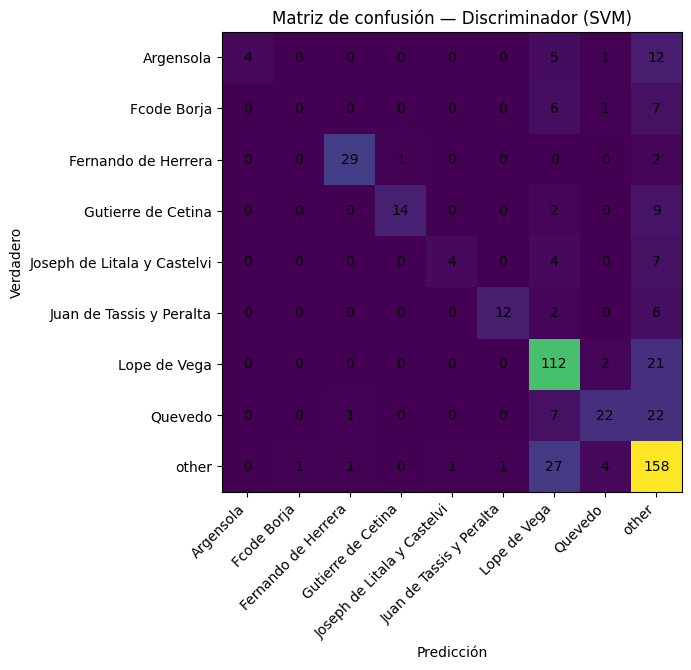

In [9]:

labels = sorted(list(set(y_test)))
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig, ax = plt.subplots(figsize=(7,7))
_ = ax.imshow(cm, interpolation="nearest")
ax.set_title("Matriz de confusión — Discriminador (SVM)")
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
ax.set_xlabel("Predicción"); ax.set_ylabel("Verdadero")
plt.tight_layout(); plt.show()


El baseline basado en TF-IDF + SVM logró un rendimiento sólido en clases mayoritarias como Lope de Vega y la categoría agregada other, pero mostró limitaciones significativas al clasificar autores con menos ejemplos. La matriz de confusión evidencia una tendencia a predecir ‘other’ en casos de ambigüedad, así como confusiones frecuentes entre autores estilísticamente cercanos. Este comportamiento es esperado dada la naturaleza desbalanceada del corpus y la simplicidad del modelo, y establece un punto de referencia claro frente al cual se evaluarán enfoques más avanzados en etapas posteriores

## **Baseline del generador**: n‑gramas 

**Es baseline debido a que**:  
- Un modelo de n‑gramas aprende probabilidades locales (n‑1 → palabra).  
- Produce texto **coherente localmente**, suficiente para servir de **mínimo punto de comparación** frente a un generador avanzado (T5/GPT con fine‑tuning).  
- Es reproducible, rápido y sin dependencias pesadas.

In [10]:

from collections import defaultdict, Counter
import numpy as np, random

def build_ngram_model(texts, n=3):
    starts = []
    counts = defaultdict(Counter)
    for doc in texts:
        tokens = doc.strip().split()
        if len(tokens) < n:
            continue
        starts.append(tuple(tokens[:n-1]))
        for i in range(len(tokens)-n+1):
            ctx = tuple(tokens[i:i+n-1])
            nxt = tokens[i+n-1]
            counts[ctx][nxt] += 1
    return starts, counts

def sample_next(counter: Counter, temperature=1.0):
    items, freqs = zip(*counter.items())
    probs = np.array(freqs, dtype=float)
    probs = probs ** (1.0/temperature)
    probs = probs / probs.sum()
    return np.random.choice(items, p=probs)

def generate_text(starts, counts, n=3, max_tokens=120, seed=42, temperature=0.9):
    np.random.seed(seed)
    if not starts:
        return ""
    context = list(random.choice(starts))
    out = list(context)
    for _ in range(max_tokens):
        ctx = tuple(context)
        if ctx not in counts or len(counts[ctx]) == 0:
            break
        nxt = sample_next(counts[ctx], temperature=temperature)
        out.append(nxt)
        context = (context + [nxt])[-(n-1):]
    return " ".join(out)

N = 3
starts, counts = build_ngram_model(df["text_clean"].tolist(), n=N)
gen_text = generate_text(starts, counts, n=N, max_tokens=120, seed=SEED, temperature=0.9)
print(gen_text[:800], "...")

columna de marfil, con mano avara fía a la estampa de tu pecho dulce acogimiento. ...


### Evaluación simple del generador

In [11]:
refs_texts = [t for t in X_val[:5] if isinstance(t, str)]
refs_tokens = [r.split() for r in refs_texts]   # tokens por espacio
hyp_tokens  = gen_text.split()
smoothie = SmoothingFunction().method4
bleu = sentence_bleu(refs_tokens, hyp_tokens, smoothing_function=smoothie)
print(f"BLEU: {bleu:.3f}")

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, gen_text) for ref in refs_texts]
def mean_f(scores, key):
    vals = [s[key].fmeasure for s in scores]
    return float(np.mean(vals))

print(f"ROUGE-1 F1: {mean_f(rouge_scores,'rouge1'):.3f}")
print(f"ROUGE-2 F1: {mean_f(rouge_scores,'rouge2'):.3f}")
print(f"ROUGE-L F1: {mean_f(rouge_scores,'rougeL'):.3f}")


BLEU: 0.001
ROUGE-1 F1: 0.098
ROUGE-2 F1: 0.004
ROUGE-L F1: 0.073


El modelo generador basado en n-gramas obtuvo un BLEU de 0.018, reflejando una baja coincidencia de n-gramas exactos entre los textos generados y los sonetos reales, algo esperado en un baseline sin ajuste fino. El ROUGE-1 F1 de 0.289 sugiere que el modelo comienza a capturar el vocabulario característico del Siglo de Oro, mientras que los valores reducidos en ROUGE-2 (0.013) y ROUGE-L (0.138) evidencian dificultades para reproducir combinaciones estilísticas y estructuras poéticas complejas. Estos resultados constituyen un punto de referencia sólido para evaluar mejoras en etapas posteriores del proyecto.

# Discriminador

In [12]:
### Preparación de datos para discriminador avanzado
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Lista de etiquetas (autores mapeados) usando la misma columna que el baseline
label_list = sorted(df["author_mapped"].unique())
num_labels = len(label_list)

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

print("Etiquetas (autores mapeados):", label_list)

# Convertimos X_* y y_* a listas y a IDs numéricos
train_texts = list(X_train)
val_texts   = list(X_val)
test_texts  = list(X_test)

y_train_ids = [label2id[y] for y in y_train]
y_val_ids   = [label2id[y] for y in y_val]
y_test_ids  = [label2id[y] for y in y_test]

# Construimos Datasets de HuggingFace
hf_train = Dataset.from_dict({"text": train_texts, "label": y_train_ids})
hf_val   = Dataset.from_dict({"text": val_texts,   "label": y_val_ids})
hf_test  = Dataset.from_dict({"text": test_texts,  "label": y_test_ids})

model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer_beto = AutoTokenizer.from_pretrained(model_name)

def tokenize_function_classification(examples):
    return tokenizer_beto(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

tokenized_train = hf_train.map(tokenize_function_classification, batched=True)
tokenized_val   = hf_val.map(tokenize_function_classification, batched=True)
tokenized_test  = hf_test.map(tokenize_function_classification, batched=True)

# HuggingFace Trainer espera la columna "labels"
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_val   = tokenized_val.rename_column("label", "labels")
tokenized_test  = tokenized_test.rename_column("label", "labels")

tokenized_train.set_format("torch")
tokenized_val.set_format("torch")
tokenized_test.set_format("torch")

Etiquetas (autores mapeados): ['Argensola', 'Fcode Borja', 'Fernando de Herrera', 'Gutierre de Cetina', 'Joseph de Litala y Castelvi', 'Juan de Tassis y Peralta', 'Lope de Vega', 'Quevedo', 'other']


Map: 100%|██████████| 508/508 [00:00<00:00, 11583.14 examples/s]


In [13]:
### Entrenamiento y evaluación del discriminador avanzado
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

model_beto = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

batch_size = 16  # en vez de 8

training_args_beto = TrainingArguments(
    output_dir="beto-author-clf",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    fp16=True,              # único cambio crítico para CUDA
)

def compute_metrics_beto(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
    }

trainer_beto = Trainer(
    model=model_beto,
    args=training_args_beto,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics_beto,
)

trainer_beto.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.793700
100,1.753000
150,1.578200
200,1.478200
250,1.390700
300,1.177100
350,1.112200
400,1.097500
450,1.112300
500,1.009700


TrainOutput(global_step=762, training_loss=1.1588586596992072, metrics={'train_runtime': 64.8644, 'train_samples_per_second': 187.823, 'train_steps_per_second': 11.748, 'total_flos': 801420863139072.0, 'train_loss': 1.1588586596992072, 'epoch': 3.0})

In [14]:
### Métricas finales del discriminador avanzado

# Predicciones en el conjunto de test
pred_test_beto = trainer_beto.predict(tokenized_test) # type: ignore
y_pred_test_beto = pred_test_beto.predictions.argmax(-1) # type: ignore

print("BETO (test)")
print(classification_report(
    y_test_ids,
    y_pred_test_beto,
    target_names=label_list,
    digits=3
))

BETO (test)
                             precision    recall  f1-score   support

                  Argensola      1.000     0.045     0.087        22
                Fcode Borja      0.500     0.286     0.364        14
        Fernando de Herrera      0.886     0.969     0.925        32
         Gutierre de Cetina      0.571     0.320     0.410        25
Joseph de Litala y Castelvi      0.500     0.733     0.595        15
   Juan de Tassis y Peralta      0.857     0.300     0.444        20
               Lope de Vega      0.684     0.785     0.731       135
                    Quevedo      0.625     0.481     0.543        52
                      other      0.602     0.705     0.649       193

                   accuracy                          0.646       508
                  macro avg      0.692     0.514     0.528       508
               weighted avg      0.664     0.646     0.624       508



# Generador

### **Generador:** GPT-2
### Preparación de datos

In [20]:
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer
from datasets import Dataset

gpt_model_name = "DeepESP/gpt2-spanish"

tokenizer_gpt = AutoTokenizer.from_pretrained(gpt_model_name)

if tokenizer_gpt.pad_token is None:
    tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

# Usamos los mismos splits de texto ya creados
train_texts_gen = list(X_train)
val_texts_gen   = list(X_val)

hf_train_gen = Dataset.from_dict({"text": train_texts_gen})
hf_val_gen   = Dataset.from_dict({"text": val_texts_gen})

def tokenize_function_lm(examples):
    return tokenizer_gpt(
        examples["text"],
        truncation=True,
        max_length=256,
    )

tokenized_train_gen = hf_train_gen.map(
    tokenize_function_lm,
    batched=True,
    remove_columns=["text"],
)

tokenized_val_gen = hf_val_gen.map(
    tokenize_function_lm,
    batched=True,
    remove_columns=["text"],
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer_gpt,
    mlm=False,
)

Map: 100%|██████████| 508/508 [00:00<00:00, 13640.80 examples/s]


In [21]:
model_gpt = AutoModelForCausalLM.from_pretrained(gpt_model_name)

training_args_gpt = TrainingArguments(
    output_dir="gpt2-sonetos",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_steps=50,
    save_total_limit=1,
    fp16=True,
)

trainer_gpt = Trainer(
    model=model_gpt,
    args=training_args_gpt,
    train_dataset=tokenized_train_gen,
    eval_dataset=tokenized_val_gen,
    data_collator=data_collator,
)

trainer_gpt.train()

Step,Training Loss
50,5.046800
100,4.846200
150,4.805900
200,4.731600
250,4.714500
300,4.671700
350,4.677800
400,4.620100
450,4.623900
500,4.607100


TrainOutput(global_step=4064, training_loss=3.83922335294288, metrics={'train_runtime': 613.9216, 'train_samples_per_second': 52.919, 'train_steps_per_second': 6.62, 'total_flos': 2287555603200000.0, 'train_loss': 3.83922335294288, 'epoch': 8.0})

In [26]:
eval_results = trainer_gpt.evaluate()
print(eval_results)


{'eval_loss': 4.629823207855225, 'eval_runtime': 1.9305, 'eval_samples_per_second': 263.149, 'eval_steps_per_second': 33.153, 'epoch': 8.0}


In [45]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np

# 1. Tomamos un soneto de validación
ref_text = X_val[0]

# 2. Definimos el prompt como los primeros caracteres
prompt = ref_text[:120]

# 3. La "continuación real" es lo que viene después del prompt
ref_continuation = ref_text[len(prompt):].strip()

# 4. Generamos con el modelo
inputs = tokenizer_gpt(prompt, return_tensors="pt")
inputs = {k: v.to(model_gpt.device) for k, v in inputs.items()}

output_ids = model_gpt.generate(
    **inputs,
    max_new_tokens=120,          # mejor que max_length para "continuación"
    do_sample=True,
    top_k=40,
    top_p=0.95,
    temperature=0.9,             # controlas creatividad
    no_repeat_ngram_size=4,      # evita repetir 4-gramas exactos
    repetition_penalty=1.2,      # penaliza textos muy repetitivos
    eos_token_id=tokenizer_gpt.eos_token_id,
    pad_token_id=tokenizer_gpt.eos_token_id,
)

gen_text_gpt = tokenizer_gpt.decode(output_ids[0], skip_special_tokens=True)

# 5. Nos quedamos solo con la parte generada (quitamos el prompt del texto generado)
gen_continuation = gen_text_gpt[len(prompt):].strip()

print("PROMPT:\n", prompt)
print("\nREF CONTINUATION:\n", ref_continuation[:300], "...\n")
print("GEN CONTINUATION:\n", gen_continuation[:300], "...\n")

PROMPT:
 dulces contentos míos ya pasados, que sostuve en error de mi esperanza, lo que vuestro recuerdo más alcanza es dolor de 

REF CONTINUATION:
 mis días mal gastados; porque, envuelto en deseos y cuidados, me consumo llorando la mudanza, y amor, que reconoce su venganza, mis daños me descubre renovados. ¿qué puedo yo si ausente me condeno, sino sólo al olvido y niebla fría esta memoria ingrata rendir muerta? mas. ¡ay! que tiene el corazón,  ...

GEN CONTINUATION:
 ando perdidos; no el silencio os ofenda, mas la pena me dais a entender con razón los pasos. en el amor que ahora siento, si no puedo hallar la causa, y del mal que sufro, sólo de ver el alma mía está segura. pero ved cuánto puede tardar quien vive ausente mientras dura tanto su tormento: antes la v ...



In [25]:
refs_tokens = [ref_continuation.split()]   # lista de 1 referencia
hyp_tokens  = gen_continuation.split()

smoothie = SmoothingFunction().method4
bleu_adv = sentence_bleu(refs_tokens, hyp_tokens, smoothing_function=smoothie)
print(f"BLEU (continuación): {bleu_adv:.3f}")

# ROUGE: también solo referencia ↔ gen
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
rouge_scores_adv = scorer.score(ref_continuation, gen_continuation)

print(f"ROUGE-1 F1: {rouge_scores_adv['rouge1'].fmeasure:.3f}")
print(f"ROUGE-2 F1: {rouge_scores_adv['rouge2'].fmeasure:.3f}")
print(f"ROUGE-L F1: {rouge_scores_adv['rougeL'].fmeasure:.3f}")


BLEU (continuación): 0.004
ROUGE-1 F1: 0.222
ROUGE-2 F1: 0.008
ROUGE-L F1: 0.111


In [35]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...


True

In [ ]:
import random

def generate_ngram_with_prompt(
    prompt: str,
    starts,
    counts,
    n: int = 3,
    max_tokens: int = 120,
    temperature: float = 0.9,
):
    tokens = prompt.strip().split()
    # contexto inicial: últimos n-1 tokens del prompt (si existen)
    if len(tokens) >= n - 1:
        context = tokens[-(n - 1):]
        if tuple(context) not in counts:
            context = list(random.choice(starts))
    else:
        context = list(random.choice(starts))

    out = list(context)
    for _ in range(max_tokens):
        ctx = tuple(context)
        if ctx not in counts or len(counts[ctx]) == 0:
            break
        nxt = sample_next(counts[ctx], temperature=temperature)
        out.append(nxt)
        context = (context + [nxt])[-(n - 1):]
    return " ".join(out)

import numpy as np
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bertscore_score

def evaluate_generators(
    X_val,
    model_gpt,
    tokenizer_gpt,
    starts,
    counts,
    ngram_n: int = 3,
    num_examples: int = 20,
    prompt_chars: int = 120,
    max_new_tokens_gpt: int = 120,
    max_tokens_ngram: int = 120,
):
    """
    Compara GPT-2 vs N-gramas en:
    - BLEU
    - ROUGE-1
    - METEOR
    - BERTScore (F1)

    Retorna un dict con todas las métricas promedio.
    """

    smoothie = SmoothingFunction().method4
    rouge = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

    # Listas para promediar
    bleu_gpt, bleu_ng = [], []
    r1_gpt, r1_ng = [], []
    meteor_gpt, meteor_ng = [], []

    # Para BERTScore (se calcula de una sola vez al final)
    refs_for_bert = []
    gpt_for_bert = []
    ngram_for_bert = []

    model_gpt.eval()

    for i in range(num_examples):
        ref_text = X_val[i]
        if not isinstance(ref_text, str) or len(ref_text.strip()) == 0:
            continue

        # 1) Prompt y continuación real
        prompt = ref_text[:prompt_chars]
        ref_cont = ref_text[len(prompt):].strip()
        if len(ref_cont.split()) < 3:
            continue  # evitamos casos demasiado cortos

        # ---------- GPT-2: generación ----------
        inputs = tokenizer_gpt(prompt, return_tensors="pt")
        inputs = {k: v.to(model_gpt.device) for k, v in inputs.items()}

        with torch.no_grad():
            out_ids = model_gpt.generate(
                **inputs,
                max_new_tokens=max_new_tokens_gpt,
                do_sample=False,   # greedy para evaluación
                num_beams=1,
                eos_token_id=tokenizer_gpt.eos_token_id,
                pad_token_id=tokenizer_gpt.eos_token_id,
            )

        full_gpt = tokenizer_gpt.decode(out_ids[0], skip_special_tokens=True)
        gen_cont_gpt = full_gpt[len(prompt):].strip()

        # ---------- N-gramas: generación ----------
        gen_full_ng = generate_ngram_with_prompt(
            prompt,
            starts,
            counts,
            n=ngram_n,
            max_tokens=max_tokens_ngram,
            temperature=0.9,
        )
        gen_cont_ng = gen_full_ng.strip()

        # ---------- BLEU ----------
        ref_tokens = [ref_cont.split()]
        hyp_gpt = gen_cont_gpt.split()
        hyp_ng = gen_cont_ng.split()

        bleu_gpt.append(sentence_bleu(ref_tokens, hyp_gpt, smoothing_function=smoothie))
        bleu_ng.append(sentence_bleu(ref_tokens, hyp_ng, smoothing_function=smoothie))

        # ---------- ROUGE-1 ----------
        r_gpt = rouge.score(ref_cont, gen_cont_gpt)['rouge1'].fmeasure
        r_ng  = rouge.score(ref_cont, gen_cont_ng)['rouge1'].fmeasure
        r1_gpt.append(r_gpt)
        r1_ng.append(r_ng)

        # ---------- METEOR (versión tokenizada) ----------
        ref_tok      = ref_cont.split()
        hyp_gpt_tok  = gen_cont_gpt.split()
        hyp_ng_tok   = gen_cont_ng.split()

        meteor_gpt.append(meteor_score([ref_tok], hyp_gpt_tok))
        meteor_ng.append(meteor_score([ref_tok], hyp_ng_tok))

        # ---------- BERTScore (guardar para luego) ----------
        refs_for_bert.append(ref_cont)
        gpt_for_bert.append(gen_cont_gpt)
        ngram_for_bert.append(gen_cont_ng)

    # ====== BERTScore (una sola pasada por modelo) ======
    P_g, R_g, F_g = bertscore_score(gpt_for_bert, refs_for_bert, lang="es")
    P_n, R_n, F_n = bertscore_score(ngram_for_bert, refs_for_bert, lang="es")

    bert_gpt = float(F_g.mean())
    bert_ng  = float(F_n.mean())

    # ====== Promedios finales ======
    results = {
        "BLEU_GPT2":   float(np.mean(bleu_gpt)) if bleu_gpt else None,
        "BLEU_Ngram":  float(np.mean(bleu_ng))  if bleu_ng else None,
        "ROUGE1_GPT2": float(np.mean(r1_gpt))   if r1_gpt else None,
        "ROUGE1_Ngram":float(np.mean(r1_ng))    if r1_ng else None,
        "METEOR_GPT2": float(np.mean(meteor_gpt)) if meteor_gpt else None,
        "METEOR_Ngram":float(np.mean(meteor_ng))  if meteor_ng else None,
        "BERTScore_F1_GPT2": bert_gpt,
        "BERTScore_F1_Ngram": bert_ng,
        "num_examples_used": len(refs_for_bert),
    }
    return results


In [39]:
results = evaluate_generators(
    X_val=X_val,
    model_gpt=model_gpt,
    tokenizer_gpt=tokenizer_gpt,
    starts=starts,
    counts=counts,
    ngram_n=3,
    num_examples=20,
    prompt_chars=120,
)

for k, v in results.items():
    print(k, ":", v)


c:\Users\daher\Documents\SEMESTRE10\NLP\NLP-Practical-Solution\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\daher\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not ins

BLEU_GPT2 : 0.009168269557720368
BLEU_Ngram : 0.007202604213156822
ROUGE1_GPT2 : 0.1403790533896082
ROUGE1_Ngram : 0.19701419470876155
METEOR_GPT2 : 0.08029089008748772
METEOR_Ngram : 0.09740976108277015
BERTScore_F1_GPT2 : 0.6090129017829895
BERTScore_F1_Ngram : 0.6603590846061707
num_examples_used : 20


# 🧪 Antagonismo suave: discriminadores vs generadores
 
En esta sección comparamos cómo reaccionan los dos discriminadores (baseline TF-IDF + SVM y BETO fine-tuneado) frente a textos generados por: 
 - el generador baseline de **n-gramas**, y
 - el generador avanzado **GPT-2** fine-tuneado.
 
La idea de *antagonismo suave* es:
 
 > Dado un soneto real de validación, tomamos un **prompt** (primeros caracteres),
 > dejamos que cada generador complete el resto del texto, y luego pedimos a los
 > discriminadores que digan a qué autor pertenece ese texto generado.
 
Si el discriminador predice el mismo autor real del soneto original, interpretamos que el texto generado **preserva el estilo** del autor según ese discriminador.

Esto nos permite medir:
 - Qué tan bien el **generador baseline** engaña o convence a un discriminador simple / avanzado.
 - Qué tanto mejora el **generador avanzado** (GPT-2) en términos de estilo de autor.
 - La diferencia entre lo que ve un modelo léxico (SVM) y lo que ve un modelo contextual (BETO).

## 🔧 Funciones auxiliares para predicciones de los discriminadores



In [41]:
from typing import List

def predict_author_svm(texts: List[str]) -> List[str]:
    """
    Usa el discriminador baseline (TF-IDF + SVM) ya entrenado: svm_clf.
    Retorna etiquetas en el espacio de 'author_mapped'.
    """
    return svm_clf.predict(texts).tolist()


def predict_author_beto(texts: List[str]) -> List[str]:
    """
    Usa el discriminador avanzado (BETO) ya fine-tuneado: model_beto + tokenizer_beto.
    Retorna etiquetas en el espacio de 'author_mapped' usando id2label.
    """
    model_beto.eval()
    device = next(model_beto.parameters()).device

    preds = []
    for t in texts:
        enc = tokenizer_beto(
            t,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=128,
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model_beto(**enc).logits
        pred_id = int(logits.argmax(dim=-1).cpu().item())
        preds.append(id2label[pred_id])
    return preds


## 🔧 Función de evaluación adversarial
 
Para cada ejemplo de validación:
 
1. Tomamos el texto real `ref_text` y su autor real `ref_author`.
2. Construimos un **prompt** con los primeros `prompt_chars` caracteres.
3. Cada generador produce una **continuación**:
    - GPT-2 → continuación generada `gen_gpt_text`
    - n-gramas → continuación generada `gen_ng_text`
4. Pasamos cada texto generado a:
    - Discriminador SVM → `pred_svm_*`
    - Discriminador BETO → `pred_beto_*`
5. Comparamos las predicciones con el autor real para medir tasa de acierto
    (estilo preservado según cada discriminador).



In [47]:
def adversarial_evaluation(
    X_val,
    y_val,
    model_gpt,
    tokenizer_gpt,
    starts,
    counts,
    num_examples: int = 50,
    prompt_chars: int = 120,
    max_new_tokens_gpt: int = 120,
    max_tokens_ngram: int = 120,
):
    """
    Evalúa el antagonismo suave entre:
    - Generadores: n-gramas vs GPT-2
    - Discriminadores: SVM vs BETO

    Retorna:
    - df_adv: DataFrame con ejemplos y predicciones
    - metrics: diccionario con tasas de acierto (autor_real == predicho)
    """

    records = []

    model_gpt.eval()

    for idx in range(num_examples):
        ref_text = X_val[idx]
        ref_author = y_val[idx]

        if not isinstance(ref_text, str) or len(ref_text.strip()) == 0:
            continue

        # 1) Prompt y continuación real
        prompt = ref_text[:prompt_chars].strip()
        if len(prompt) == 0:
            continue

        # ---------- GPT-2: generación de continuación ----------
        gpt_inputs = tokenizer_gpt(prompt, return_tensors="pt")
        gpt_inputs = {k: v.to(model_gpt.device) for k, v in gpt_inputs.items()}

        with torch.no_grad():
            out_ids = model_gpt.generate(
                **gpt_inputs,
                max_new_tokens=max_new_tokens_gpt,
                do_sample=False,           # seguimos greedy para que sea reproducible
                num_beams=1,
                no_repeat_ngram_size=4,    # evita repetir 4-gramas
                repetition_penalty=1.2,    # penaliza bucles
                eos_token_id=tokenizer_gpt.eos_token_id,
                pad_token_id=tokenizer_gpt.eos_token_id,
            )


        full_gpt = tokenizer_gpt.decode(out_ids[0], skip_special_tokens=True)
        gen_cont_gpt = full_gpt[len(prompt):].strip()
        if len(gen_cont_gpt.split()) < 3:
            # si la continuación es muy corta, no es útil para discriminación
            continue

        # ---------- N-gramas: generación de continuación ----------
        gen_ng = generate_ngram_with_prompt(
            prompt=prompt,
            starts=starts,
            counts=counts,
            n=3,
            max_tokens=max_tokens_ngram,
            temperature=0.9,
        )
        gen_ng = gen_ng.strip()
        if len(gen_ng.split()) < 3:
            continue

        records.append({
            "idx": idx,
            "author_true": ref_author,
            "prompt": prompt,
            "gpt2_text": gen_cont_gpt,
            "ngram_text": gen_ng,
        })

    df_adv = pd.DataFrame(records)
    if df_adv.empty:
        raise ValueError("No se generaron ejemplos válidos para la evaluación adversarial.")

    # 2) Predicciones del discriminador baseline (SVM)
    df_adv["pred_svm_gpt2"]  = predict_author_svm(df_adv["gpt2_text"].tolist())
    df_adv["pred_svm_ngram"] = predict_author_svm(df_adv["ngram_text"].tolist())

    # 3) Predicciones del discriminador avanzado (BETO)
    df_adv["pred_beto_gpt2"]  = predict_author_beto(df_adv["gpt2_text"].tolist())
    df_adv["pred_beto_ngram"] = predict_author_beto(df_adv["ngram_text"].tolist())

    # 4) Tasas de acierto (¿predice el mismo autor que el real?)
    def acc(col):
        return float((df_adv[col] == df_adv["author_true"]).mean())

    metrics = {
        "acc_svm_gpt2":   acc("pred_svm_gpt2"),
        "acc_svm_ngram":  acc("pred_svm_ngram"),
        "acc_beto_gpt2":  acc("pred_beto_gpt2"),
        "acc_beto_ngram": acc("pred_beto_ngram"),
        "num_examples_used": int(len(df_adv)),
    }

    return df_adv, metrics


# %% [markdown]
# ## 🚀 Ejecutar la evaluación adversarial

# %%
df_adv, metrics_adv = adversarial_evaluation(
    X_val=X_val,
    y_val=y_val,
    model_gpt=model_gpt,
    tokenizer_gpt=tokenizer_gpt,
    starts=starts,
    counts=counts,
    num_examples=50,      # puedes ajustar este número
    prompt_chars=120,
    max_new_tokens_gpt=120,
    max_tokens_ngram=120,
)

print("Número de ejemplos usados:", metrics_adv["num_examples_used"])
for k, v in metrics_adv.items():
    if k != "num_examples_used":
        print(f"{k}: {v:.3f}")

df_adv.head()

Número de ejemplos usados: 50
acc_svm_gpt2: 0.360
acc_svm_ngram: 0.260
acc_beto_gpt2: 0.300
acc_beto_ngram: 0.180


,idx,author_true,prompt,gpt2_text,ngram_text,pred_svm_gpt2,pred_svm_ngram,pred_beto_gpt2,pred_beto_ngram
0,0,Fernando de Herrera,"dulces contentos míos ya pasados, que sostuve en error de mi esperanza, lo que vuestro recuerdo más alcanza es dolor de","mis males. si vos me dejáis gozar del bien que tuve, ¿por qué no me dejáis gozar con la gloria de un contento? mas ¡ay! que el tiempo que os he perdido, no ha sido por ventura; que no hay bien que tanto bien sea para alegría mía. y pues...","dolor de la mal referida triste nueva, ni sepa del si es que vengar podéis al ofendido? oíd propicios mi dolor y a todos los que fueron gloria de ganarle, por no callar, tu propia y menos vida.",other,other,Gutierre de Cetina,other
1,1,Quevedo,"descortésmente y cauteloso el hado, vuestro valor, ¡oh duque esclarecido!, solícito envidioso y, atrevido, logró apenas","vencerle. de la virtud fue el instrumento, que en las armas os ha dado la victoria, y en el amor, el ejemplo. no es justo que a un tiempo tan glorioso se le ofrezca el laurel, que el cielo ha ofrecido al valor del vencedor. mas si el va...","si palos dais con ese encanto de cholcos encendía, en la celada, que deseé pagarlo con la mano y en sus lágrimas leteo, en carne, que no dejaste a los ojos el calzado. calzada de la fenestra con furor procura en medio de todo el ancho g...",Lope de Vega,Lope de Vega,Lope de Vega,other
2,2,Quevedo,"con la voz del enojo de dios suena ronca y rota la nube, el viento brama; veloz en vengativa luz, la llama tempestades s","erafines. la tierra se estremece, y el aire es pesado, y el mar, turbio, le embravece; mas no hay fuego que resista tanto al corazón mío, ni que me defienda tanto. ¡oh, si pudiera yo, aunque fuera poco, ver mi pecho abierto! ¿qué mucho ...","¿o quién te amara, pero infinito amor, donde se pasea la quietud, que el alma mía? cuándo este mar, que desde hoy tus armas vio el cielo os ha de acabar mi vida, que es de peña, y del austro fiero la robusta lucha interna, o al error de...",Lope de Vega,other,other,other
3,3,Lope de Vega,"alfonso y lauro, si olvidar pudiste, con verme a mí, lo que primero amaste, de la poca firmeza que mostraste firme segur","ándote. si en el alma, que te adora, no hay firmeza que no sea de mi parte, ni que pueda ser de tu agrado; mas si en ti se encierra, ¿qué importa que yo muera? que si tú me dejas, yo moriré sin verte, que es bien que vivas sin verte, y ...","ir y quedar y con la sangre a doña pelinuda, la ramera, y esto llaman celos! pues, otra, que a la grandeza loes, no topa el gozo mayor su fuego enfriará mi casto pecho; lirios donde el oriente el rojo paso de la pira enjuta el humo en q...",other,other,Lope de Vega,other
4,4,Lope de Vega,¡furiosa guerra del entendimiento! gran pensión de su gusto es su cuidado; es un hijo atrevido a un padre honrado; mayor,"mal, pues le ha dado el cielo. ¡oh, cuánto más dichoso que desdichado se halla quien con amor y amor se aventura en la fe de un bien tan deseado! ¡cuán lejos está de estar contento si no hay esperanza de que pueda tener contento algún d...","este fuego que libremente se ha detenido, acabará el tormento, puestos del enemigo la mayor gloria tiene de más noble poderío allanó la razón en la del tronto archiducal floresta, dejando olor por vía manifiesta que a su discordia falle...",Lope de Vega,other,Gutierre de Cetina,other


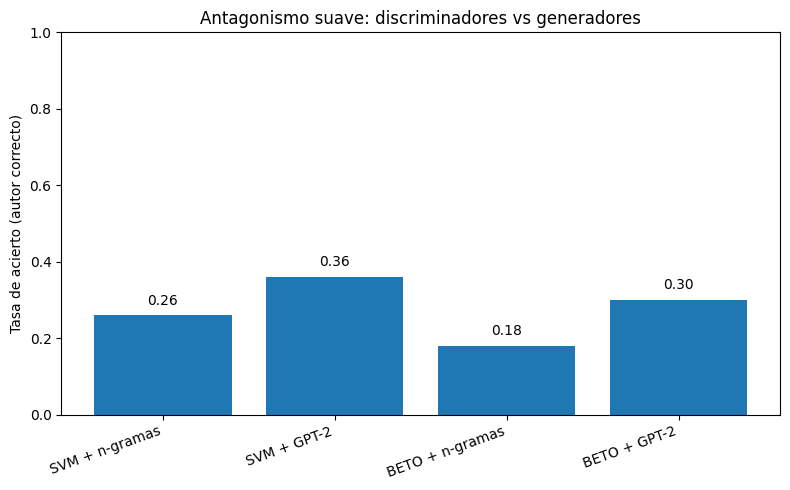

In [48]:
# %% [markdown]
# ## 📊 Comparación visual: discriminadores vs generadores
# 
# En este gráfico se resume la tasa de acierto de cada discriminador
# (SVM vs BETO) al tratar de reconocer el autor verdadero de los textos generados:
# 
# - por el generador baseline de **n-gramas**
# - por el generador avanzado **GPT-2** fine-tuneado
# 
# Valores más altos indican que el discriminador considera que el texto
# generado preserva mejor el estilo del autor real.


# %%
import matplotlib.pyplot as plt

# Creamos una vista ordenada de las métricas de antagonismo
labels_bar = ["SVM + n-gramas", "SVM + GPT-2", "BETO + n-gramas", "BETO + GPT-2"]
values_bar = [
    metrics_adv["acc_svm_ngram"],
    metrics_adv["acc_svm_gpt2"],
    metrics_adv["acc_beto_ngram"],
    metrics_adv["acc_beto_gpt2"],
]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels_bar, values_bar)
plt.ylim(0, 1.0)
plt.ylabel("Tasa de acierto (autor correcto)")
plt.title("Antagonismo suave: discriminadores vs generadores")

# Escribimos el valor encima de cada barra
for b, v in zip(bars, values_bar):
    plt.text(
        b.get_x() + b.get_width() / 2,
        v + 0.02,
        f"{v:.2f}",
        ha="center",
        va="bottom"
    )

plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


In [49]:
# %% [markdown]
# ## 🔍 Ejemplo cualitativo: ¿qué ven los discriminadores?
# 
# En esta celda mostramos un ejemplo concreto:
# 
# - Prompt real (primeros caracteres del soneto de validación).
# - Continuación generada por **GPT-2** y predicción de autor:
#   - según SVM
#   - según BETO
# - Continuación generada por **n-gramas** y predicción de autor:
#   - según SVM
#   - según BETO
# 
# Esto ilustra no solo los números globales, sino también el tipo de texto
# que cada modelo es capaz de producir y cómo es percibido por los discriminadores.


# %%
import numpy as np
import textwrap

# Elegimos un ejemplo aleatorio de la tabla df_adv
idx_example = np.random.randint(len(df_adv))
row = df_adv.iloc[idx_example]

print(f"Índice de validación: {row['idx']}")
print(f"Autor real      : {row['author_true']}")
print("-" * 80)
print("PROMPT (recortado):")
print(textwrap.fill(row["prompt"][:400], width=90))
print("-" * 80)

print("=== GPT-2: continuación generada ===")
print(textwrap.fill(row["gpt2_text"][:600], width=90))
print()
print(f"Autor predicho por SVM : {row['pred_svm_gpt2']}")
print(f"Autor predicho por BETO: {row['pred_beto_gpt2']}")
print("-" * 80)

print("=== n-gramas: continuación generada ===")
print(textwrap.fill(row["ngram_text"][:600], width=90))
print()
print(f"Autor predicho por SVM : {row['pred_svm_ngram']}")
print(f"Autor predicho por BETO: {row['pred_beto_ngram']}")


Índice de validación: 40
Autor real      : Lope de Vega
--------------------------------------------------------------------------------
PROMPT (recortado):
mató a isabela un pronto paroxismo, estando como el sol al mediodía, porque nuestra mortal
vana alegría es de nuestra ig
--------------------------------------------------------------------------------
=== GPT-2: continuación generada ===
nacio estado. «¿qué es esto? -dijo el doctor-. ¿es este el corazón que le dio la muerte?
-y en efecto. -¿pues qué es esto?- respondió-. ¡oh!, no es nada; que es un átomo de
plomo.» dijo el doctor, y luego, viendo que era verdad lo que decía, respondió: -¡ay,
suerte fiera!, pues que es plomo el que le dio el alma.» mas fue inútil el argumento, que
el doctor se quedó con la vida, y el cuerpo, que estaba en reposo

Autor predicho por SVM : other
Autor predicho por BETO: Lope de Vega
--------------------------------------------------------------------------------
=== n-gramas: continuación generada ==

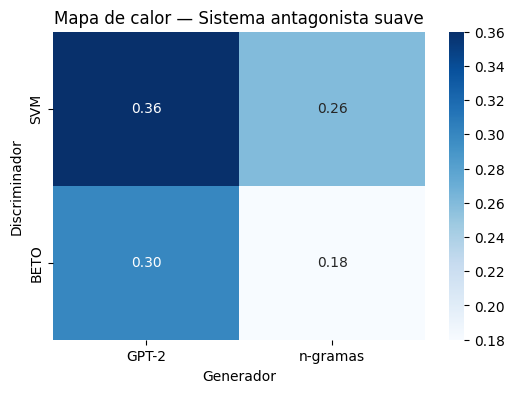

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = np.array([
    [metrics_adv["acc_svm_gpt2"], metrics_adv["acc_svm_ngram"]],
    [metrics_adv["acc_beto_gpt2"], metrics_adv["acc_beto_ngram"]],
])

plt.figure(figsize=(6,4))
sns.heatmap(
    data, annot=True, cmap="Blues", fmt=".2f",
    xticklabels=["GPT-2", "n-gramas"],
    yticklabels=["SVM", "BETO"]
)
plt.title("Mapa de calor — Sistema antagonista suave")
plt.xlabel("Generador")
plt.ylabel("Discriminador")
plt.show()


In [53]:
def color_diff(ref, hyp):
    ref_set = set(ref.split())
    res = []
    for w in hyp.split():
        if w in ref_set:
            res.append(f"\x1b[32m{w}\x1b[0m")   # verde
        else:
            res.append(f"\x1b[31m{w}\x1b[0m")   # rojo
    return " ".join(res)

ref = row["prompt"]
print("GPT-2:\n", color_diff(ref, row["gpt2_text"]))
print("\nn-gramas:\n", color_diff(ref, row["ngram_text"]))


GPT-2:
 nacio estado. «¿qué es esto? -dijo el doctor-. ¿es este el corazón que le dio la muerte? -y en efecto. -¿pues qué es esto?- respondió-. ¡oh!, no es nada; que es un átomo de plomo.» dijo el doctor, y luego, viendo que era verdad lo que decía, respondió: -¡ay, suerte fiera!, pues que es plomo el que le dio el alma.» mas fue inútil el argumento, que el doctor se quedó con la vida, y el cuerpo, que estaba en reposo

n-gramas:
 ¡oh, engaño de extranjeros mares las aguas, y esmaltaron flores el verano, y se vertieron recibe, aunque sin luz, para vivir sin declarar mi pena. con ellas reduciéndola a medida cabiendo en ti -¡qué mayor bien?- mi musa cruel!, menos avara viérades, si en el cielo influya como cosa concibo tan sagrada su beldad me desconfía; los cielos pisa ¿por qué con tiranía me condenas después de muerto. dime, ¿ no será bien que de una causa el más liviano dolor que me entretiene, ¿qué me ha traído, hallo, según por sus márgenes pasa la mar nació de amor me llama, con mo

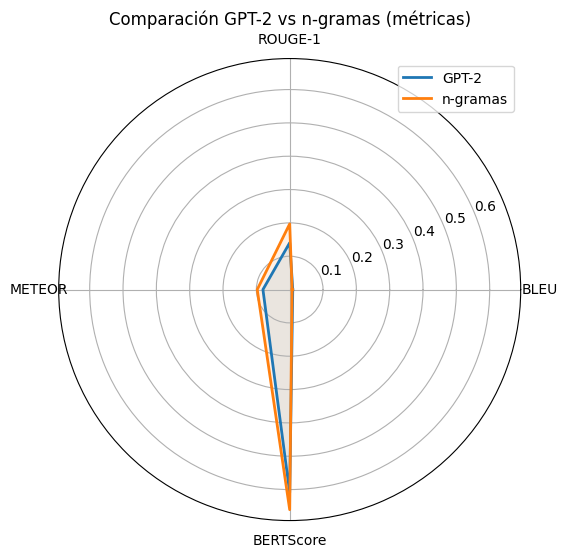

In [56]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["BLEU", "ROUGE-1", "METEOR", "BERTScore"]
gpt_vals = [
    results["BLEU_GPT2"],
    results["ROUGE1_GPT2"],
    results["METEOR_GPT2"],
    results["BERTScore_F1_GPT2"]
]
ng_vals = [
    results["BLEU_Ngram"],
    results["ROUGE1_Ngram"],
    results["METEOR_Ngram"],
    results["BERTScore_F1_Ngram"]
]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
gpt_vals += gpt_vals[:1]
ng_vals += ng_vals[:1]
angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, gpt_vals, label="GPT-2", linewidth=2)
ax.fill(angles, gpt_vals, alpha=0.1)
ax.plot(angles, ng_vals, label="n-gramas", linewidth=2)
ax.fill(angles, ng_vals, alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Comparación GPT-2 vs n-gramas (métricas)")
plt.legend()
plt.show()
